In [1]:
pip install pandas numpy dtaidistance
pip install fastdtw



   ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
    --------------------------------------- 0.0/1.1 MB 640.0 kB/s eta 0:00:02
   --- ------------------------------------ 0.1/1.1 MB 1.1 MB/s eta 0:00:01
   ------------ --------------------------- 0.3/1.1 MB 2.9 MB/s eta 0:00:01
   -------------------------------- ------- 0.9/1.1 MB 5.5 MB/s eta 0:00:01
   ---------------------------------------  1.1/1.1 MB 5.7 MB/s eta 0:00:01
   ---------------------------------------- 1.1/1.1 MB 5.2 MB/s eta 0:00:00


In [105]:
import pandas as pd
import numpy as np
from scipy.signal import detrend
import matplotlib.pyplot as plt
from dtaidistance import dtw


ModuleNotFoundError: No module named 'cudf'

In [97]:
# Load datasets
df1 = pd.read_csv('https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv', parse_dates=['date'])
df2 = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Moderna\\IQVIA\\iqvia_zip.csv', parse_dates=['Date'])

data = df2.dropna()
data = data.dropna(subset=['PROVIDER_ZIP'])
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].astype(str).str.strip()
data = data[data['PROVIDER_ZIP'] != "\"\""]
data["PROVIDER_ZIP"] = data["PROVIDER_ZIP"].str.replace("\"","")
data = data.sort_values(by=['PROVIDER_ZIP', 'Date'])

data['zip'] = data['PROVIDER_ZIP'].astype(str).str.split('.',expand=True)[0]
data['zip'] = np.where(data['zip'].str.len()==3,'00'+data['zip'],np.where(data['zip'].str.len()==4,'0'+data['zip'],data['zip']))
data['zip3'] = data['zip'].str.slice(stop=3)
data = data[['Date','zip3','CLM_CNT']]
data = data.groupby(['zip3','Date']).sum()

# filter on xip codes that have at least 10 data points
data = data.groupby('zip3').filter(lambda x: len(x)>10)
data.reset_index(inplace=True)

#grouped_sum = data.groupby('Date')['CLM_CNT'].transform('sum')
#data['natl_admins'] = grouped_sum
#data['shares'] = (data['CLM_CNT'] / data['natl_admins'])
df2=data
df2

,zip3,Date,CLM_CNT
0,006,2022-01-07,13087
1,006,2022-01-14,21158
2,006,2022-01-21,18672
3,006,2022-01-28,15378
4,006,2022-02-04,12245
...,...,...,...
93444,999,2023-12-29,11
93445,999,2024-01-05,11
93446,999,2024-01-12,12
93447,999,2024-01-19,9


In [98]:
df2 = data.groupby('Date').sum(['CLM_CNT']).reset_index()
df2

,Date,CLM_CNT
0,2022-01-07,4488095
1,2022-01-14,4523297
2,2022-01-21,3465159
3,2022-01-28,2847044
4,2022-02-04,2106287
...,...,...
103,2023-12-29,486757
104,2024-01-05,535153
105,2024-01-12,496408
106,2024-01-19,328782


In [99]:
df1

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001
...,...,...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,42.722000,12.230,54.014000,12.652,-11.525,-1.418,45.986500
69676,2018-06-26 19:00:00,38.868000,10.052,49.859001,10.669,-11.525,-1.418,45.986500
69677,2018-06-26 19:15:00,39.622002,11.057,50.448002,11.795,-10.299,-1.418,45.546501
69678,2018-06-26 19:30:00,40.459999,11.392,51.841999,11.929,-11.536,-1.418,45.546501


In [31]:
df2

Date
2022-01-07    4488095
2022-01-14    4523297
2022-01-21    3465159
2022-01-28    2847044
2022-02-04    2106287
               ...   
2023-12-29     486757
2024-01-05     535153
2024-01-12     496408
2024-01-19     328782
2024-01-26     266723
Name: CLM_CNT, Length: 108, dtype: int64

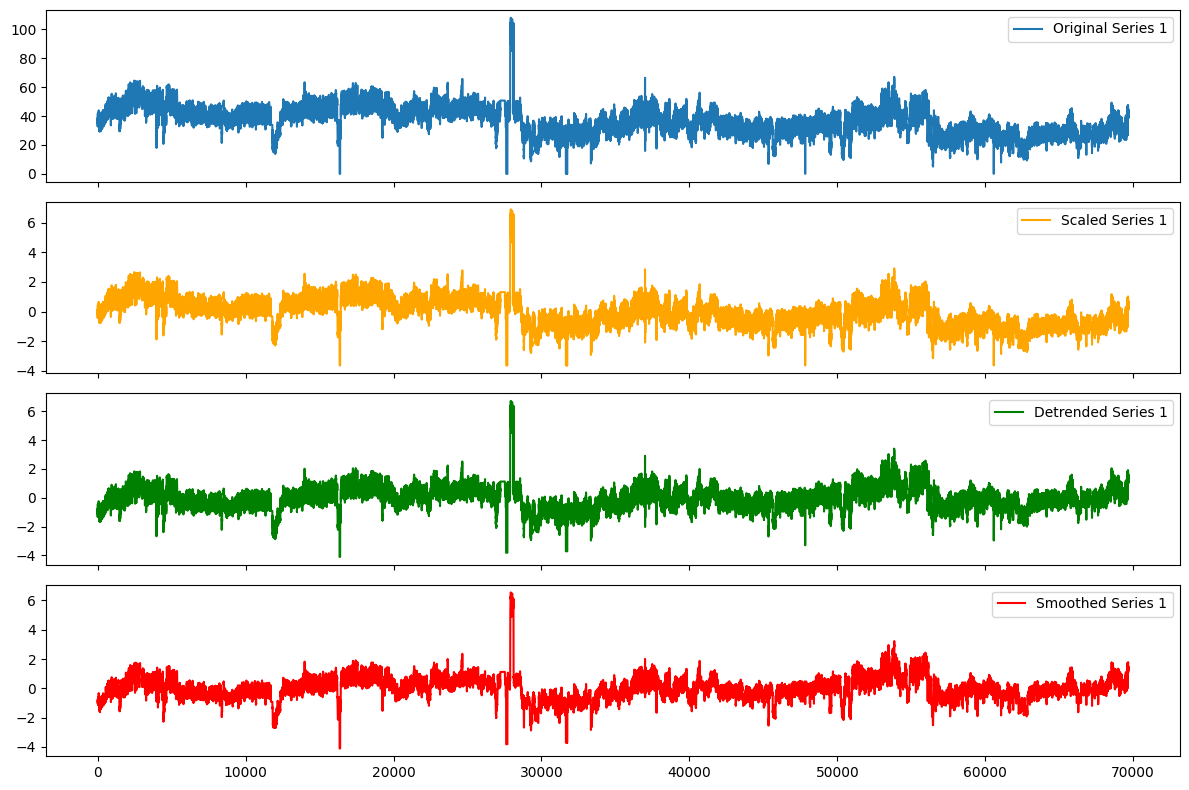

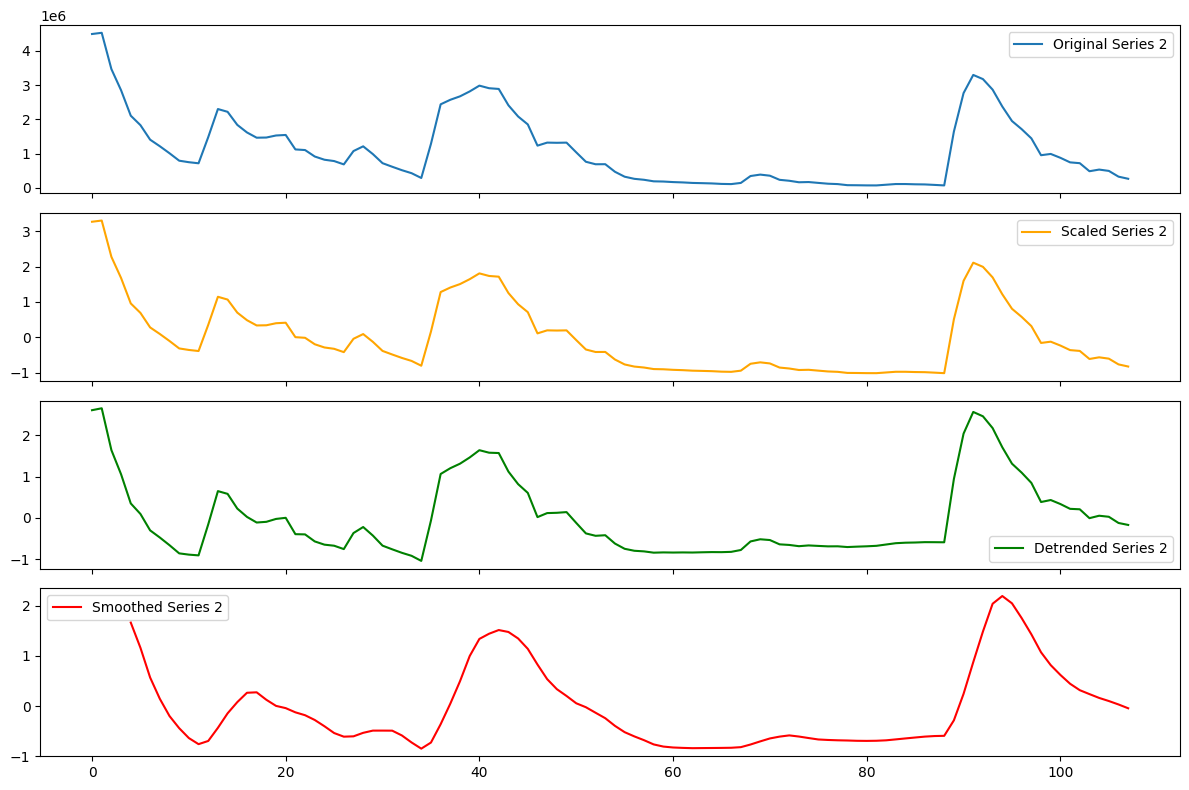

In [100]:

# Function to preprocess and plot
def preprocess_and_plot(series, label):
    fig, axs = plt.subplots(4, 1, figsize=(12, 8), sharex=True)

    # Original
    axs[0].plot(series, label=f'Original {label}')
    axs[0].legend()

    # Scaling
    scaled_series = (series - np.mean(series)) / np.std(series)
    axs[1].plot(scaled_series, label=f'Scaled {label}', color='orange')
    axs[1].legend()

    # Detrending
    detrended_series = detrend(scaled_series)
    axs[2].plot(detrended_series, label=f'Detrended {label}', color='green')
    axs[2].legend()

    # Smoothing
    smoothed_series = pd.Series(detrended_series).rolling(window=5).mean().dropna()
    axs[3].plot(smoothed_series, label=f'Smoothed {label}', color='red')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

    return smoothed_series.values

series1 = df1['HUFL'].values
series2 = df2['CLM_CNT'].values

processed_series1 = preprocess_and_plot(series1, 'Series 1')
processed_series2 = preprocess_and_plot(series2, 'Series 2')


In [102]:

# Compute DTW distance
from dtaidistance import dtw
distance = dtw.distance(processed_series1, processed_series2)
print(f'DTW Distance: {distance}')


DTW Distance: 172.42266529323734


In [103]:
df3 = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Roark-Subway\\rest_only_transactions000000000000.csv.gz', parse_dates=['TRANSACTION_DATE'])
df3 = df3.dropna(subset=['ZIPCODE'])
df3['zip3'] = df3['ZIPCODE'].astype(str).str.slice(stop=3)
df3 = df3.groupby(['TRANSACTION_DATE']).sum(['GROSS_TRANSACTION_AMOUNT']).reset_index()
df3

C:\Users\IqraImtiaz\AppData\Local\Temp\ipykernel_28960\409992073.py:1: DtypeWarning: Columns (23,24,25,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv('C:\\Users\\IqraImtiaz\\OneDrive - keystonestrategy.com\\Documents\\Roark-Subway\\rest_only_transactions000000000000.csv.gz', parse_dates=['TRANSACTION_DATE'])


,TRANSACTION_DATE,GROSS_TRANSACTION_AMOUNT,MERCHANT_POSTAL_CODE,MERCHANT_CATEGORY_CODE,ENTITY_CONFIDENCE_SCORE,LOCATION_CONFIDENCE_SCORE,ZIPCODE
0,2017-10-01 09:00:23,15.35,0.0,5814,1.0000,1.0,37188.0
1,2017-10-02 10:33:17,5.00,83467.0,5814,1.0001,1.0,83467.0
2,2017-10-02 12:13:21,1.86,0.0,5814,1.0001,1.0,12866.0
3,2017-10-02 14:41:05,2.22,93618.0,5814,1.0001,1.0,93618.0
4,2017-10-03 11:32:37,52.32,0.0,5812,1.0001,1.0,27262.0
...,...,...,...,...,...,...,...
52028,2023-12-17 21:41:34,35.61,43219.0,5812,1.0000,1.0,43219.0
52029,2023-12-17 21:42:12,20.90,33880.0,5814,1.0000,1.0,33880.0
52030,2023-12-17 22:29:57,6.64,32696.0,5814,1.0000,1.0,32696.0
52031,2023-12-17 23:29:56,41.83,67212.0,5812,1.0000,1.0,67212.0


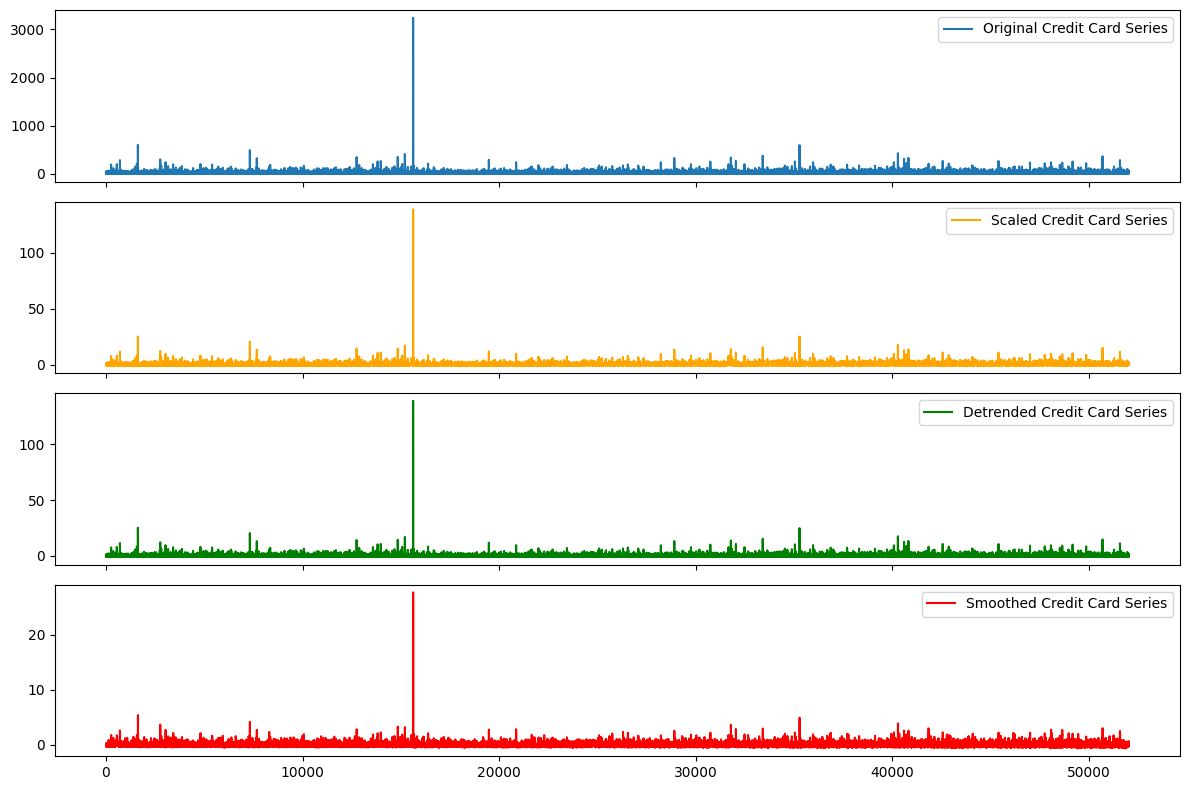

In [93]:
series3 = df3['GROSS_TRANSACTION_AMOUNT'].values

processed_series3 = preprocess_and_plot(series3, 'Credit Card Series')

In [104]:
distance = dtw.distance(processed_series2, processed_series3)
print(f'DTW Distance: {distance}')

DTW Distance: 102.68821168881384
